## 02_GriddedDiagnostics_Dewpoint_CFSR: Compute derived quantities using MetPy

## In this notebook, we'll cover the following:
1. Select a date and access various CFSR Datasets
2. Subset the desired Datasets along their dimensions
3. Calculate and visualize dewpoint.

# <span style="color:purple">0) Preliminaries </span>

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# <span style="color:purple">1) Specify a starting and ending date/time, and access several CFSR Datasets</span>

In [3]:
startYear = 2013
startMonth = 5
startDay = 31
startHour = 12
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 2013
endMonth = 5
endDay = 31
endHour = 18
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)


### Create Xarray `Dataset` objects

In [4]:
dsZ = xr.open_dataset ('/cfsr/data/%s/g.%s.0p5.anl.nc' % (startYear, startYear))
dsT = xr.open_dataset ('/cfsr/data/%s/t.%s.0p5.anl.nc' % (startYear, startYear))
dsU = xr.open_dataset ('/cfsr/data/%s/u.%s.0p5.anl.nc' % (startYear, startYear))
dsV = xr.open_dataset ('/cfsr/data/%s/v.%s.0p5.anl.nc' % (startYear, startYear))
dsW = xr.open_dataset ('/cfsr/data/%s/w.%s.0p5.anl.nc' % (startYear, startYear))
dsQ = xr.open_dataset ('/cfsr/data/%s/q.%s.0p5.anl.nc' % (startYear, startYear))
dsSLP = xr.open_dataset ('/cfsr/data/%s/pmsl.%s.0p5.anl.nc' % (startYear, startYear))

# <span style="color:purple">2) Specify a date/time range, and subset the desired `Dataset`s along their dimensions.</span>

Create a list of date and times based on what we specified for the initial and final times, using Pandas' date_range function

In [4]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

DatetimeIndex(['2013-05-31 12:00:00', '2013-05-31 18:00:00'], dtype='datetime64[ns]', freq='6H')

In [5]:
# Areal extent
lonW = -105
lonE = -90
latS = 31
latN = 39
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
latRange = np.arange(latS,latN+.5,.5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+.5,.5) # Need to match longitude values to those of the coordinate variable

Specify the pressure level.

In [6]:
# Vertical level specificaton
pLevel = 900
levStr = f'{pLevel}'

We will calculate dewpoint and theta-e, which depend on temperature and specific humidity (and also pressure, as we will see), so read in those arrays. Read in U and V as well if we wish to visualize wind vectors.

### Now create objects for our desired DataArrays based on the coordinates we have subsetted.

In [7]:
# Data variable selection
U = dsU['u'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
V = dsV['v'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
Q = dsQ['q'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
T = dsT['t'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)

Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [8]:
lats = T.lat
lons = T.lon

# <span style="color:purple">3) Calculate and visualize dewpoint.</span>

Let's examine the MetPy diagnostic that calculates dewpoint if specific humidity is available
[Dewpoint from specific humidity]:(https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dewpoint_from_specific_humidity.html)<hr>

We can see that this function requires us to pass in arrays of pressure, temperature, and specific humidity. In this case, <i>pressure is constant everywhere</i>, since we are operating on an isobaric surface.

As such, we need to be sure we are attaching units to our previously specified pressure level.

In [9]:
#Attach units to pLevel for use in MetPy with new variable, P:
P = pLevel*units['hPa']

In [10]:
P

900 <Unit('hectopascal')>

Now, we have everything we need to calculate dewpoint.

In [11]:
Td = mpcalc.dewpoint_from_specific_humidity(P, T, Q)

In [12]:
Td

Magnitude,[[[-0.3837890625 -1.5863037109375 0.248291015625 ... 15.448211669921875 16.0025634765625 16.368133544921875] [0.464263916015625 -0.7801513671875 -1.224639892578125 ... 15.21038818359375 16.00018310546875 16.526611328125] [-0.194061279296875 -0.55340576171875 -1.938995361328125 ... 15.33770751953125 16.094940185546875 16.6693115234375] ... [-0.562957763671875 -4.129302978515625 -4.43817138671875 ... 17.189544677734375 17.470367431640625 17.692535400390625] [0.62823486328125 -1.87579345703125 -1.2958984375 ... 16.63201904296875 17.188995361328125 17.823822021484375] [5.501556396484375 1.937469482421875 0.936431884765625 ... 16.702728271484375 17.072357177734375 18.004791259765625]] [[0.276519775390625 -0.212646484375 -0.86480712890625 ... 17.48443603515625 17.495941162109375 17.62957763671875] [-1.87957763671875 -2.548004150390625 -3.898590087890625 ... 17.194427490234375 17.2193603515625 17.6092529296875] [-4.188720703125 -4.0728759765625 -4.871673583984375 ... 16.726654052734375 16.651092529296875 17.28790283203125] ... [-5.34002685546875 -7.927154541015625 -7.94287109375 ... 17.734283447265625 17.521453857421875 17.509918212890625] [-7.479644775390625 -8.92950439453125 -8.04937744140625 ... 17.927764892578125 17.442962646484375 17.329254150390625] [-4.2552490234375 -6.484710693359375 -7.503143310546875 ... 17.855255126953125 17.419830322265625 17.134918212890625]]]
Units,degree_Celsius


Notice the units are in degrees Celsius.

Let's do a quick visualization. 

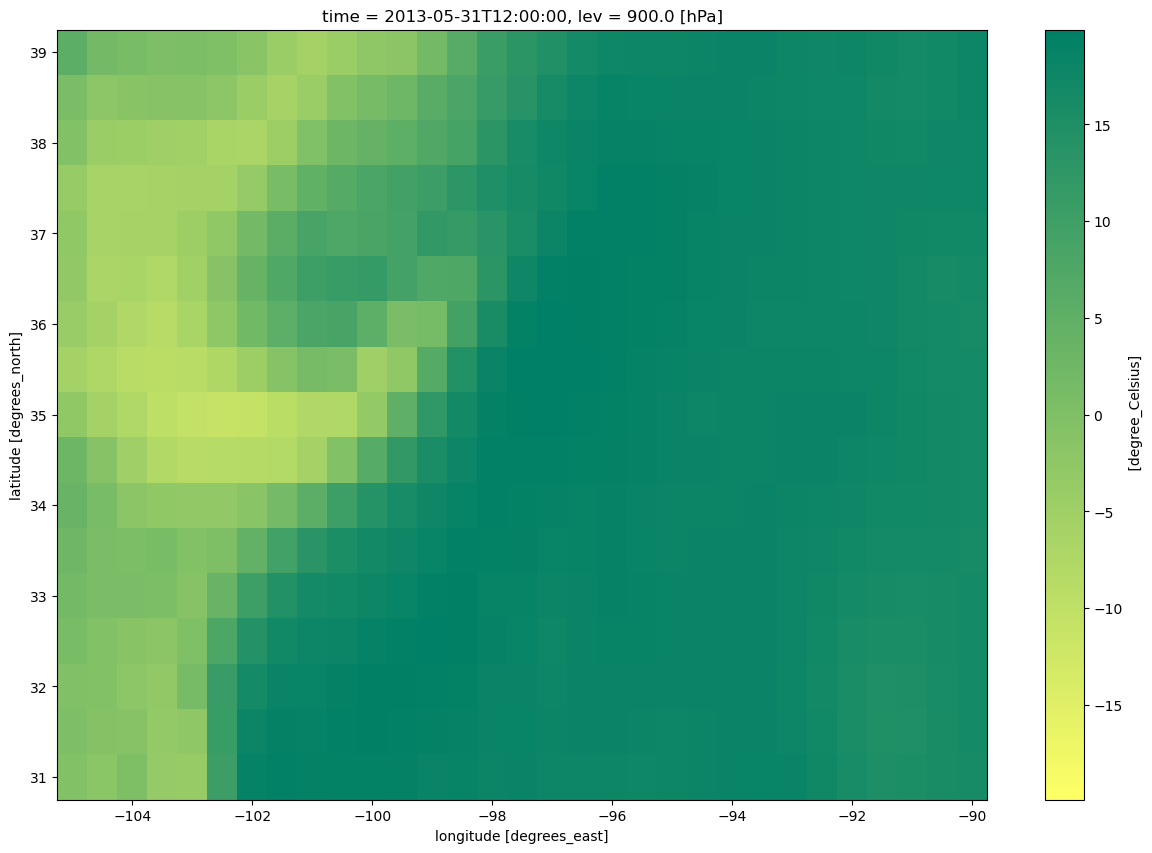

In [13]:
Td.sel(time=startDateTime).plot(figsize=(15,10),cmap='summer_r')

### Find the min/max values (no scaling necessary). Use these to inform the setting of the contour fill intervals.

In [14]:
minTd = Td.min().values
maxTd = Td.max().values
print (minTd, maxTd)

-11.092773 20.672699


In [15]:
TdInc = 2
TdContours = np.arange (-12, 24, TdInc)

### Now, let's plot filled contours of dewpoint, and wind barbs on the map. 

Convert U and V to knots

In [16]:
UKts = U.metpy.convert_units('kts')
VKts = V.metpy.convert_units('kts')

In [17]:
constrainLat, constrainLon = (0.5, 4.0)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

Processing 2013-05-31 12:00:00
Processing 2013-05-31 18:00:00


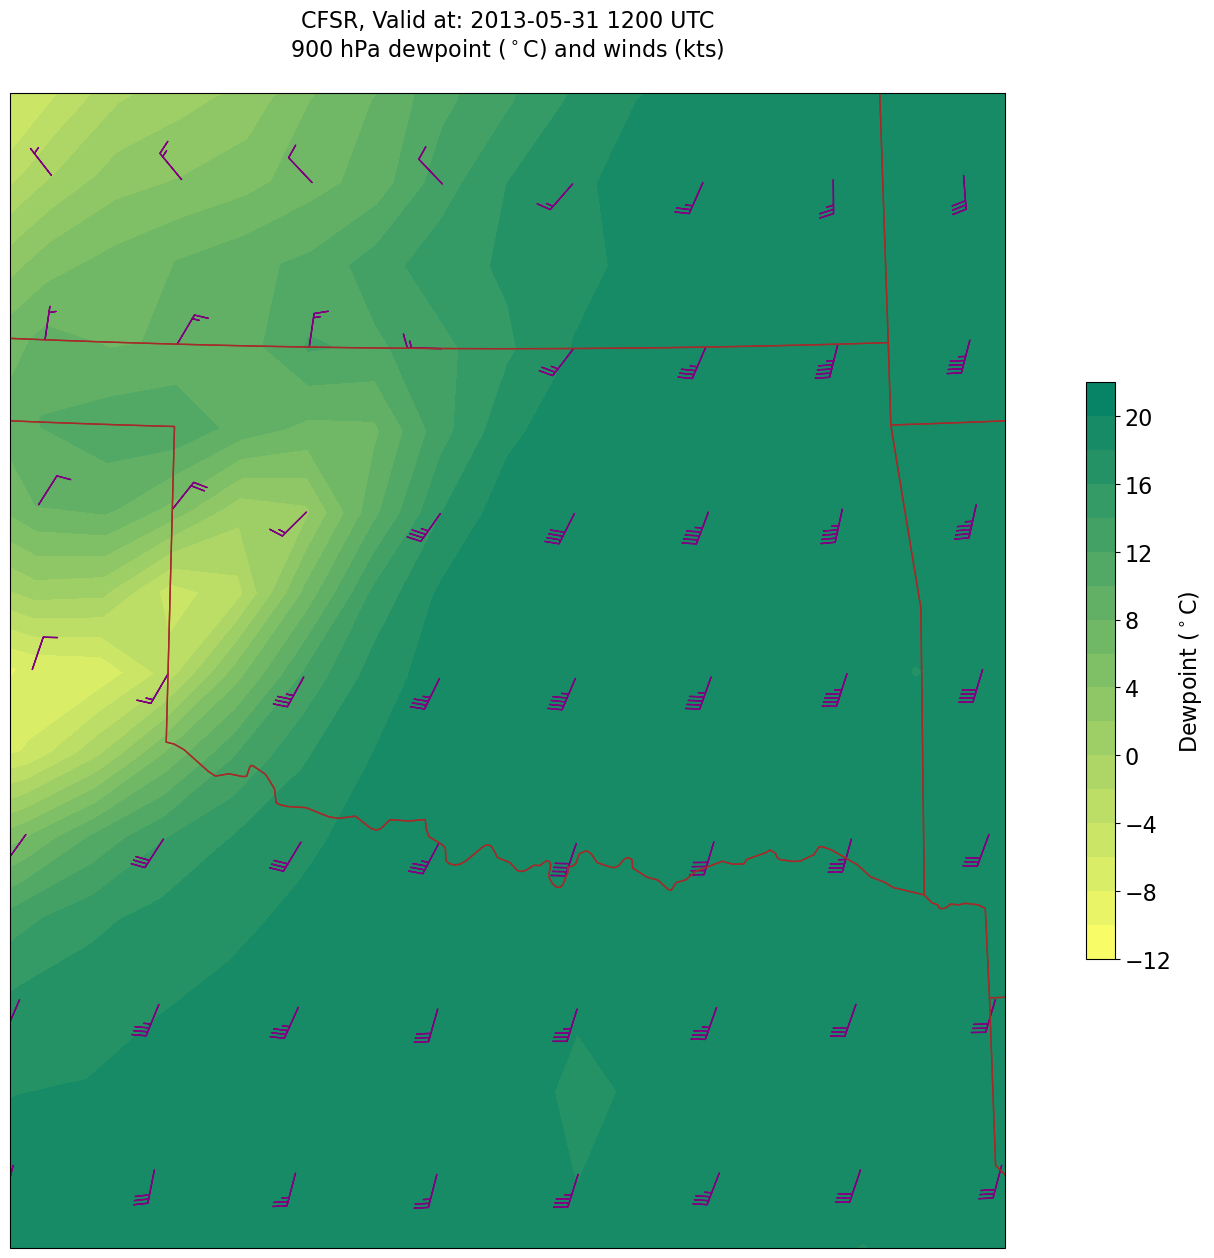

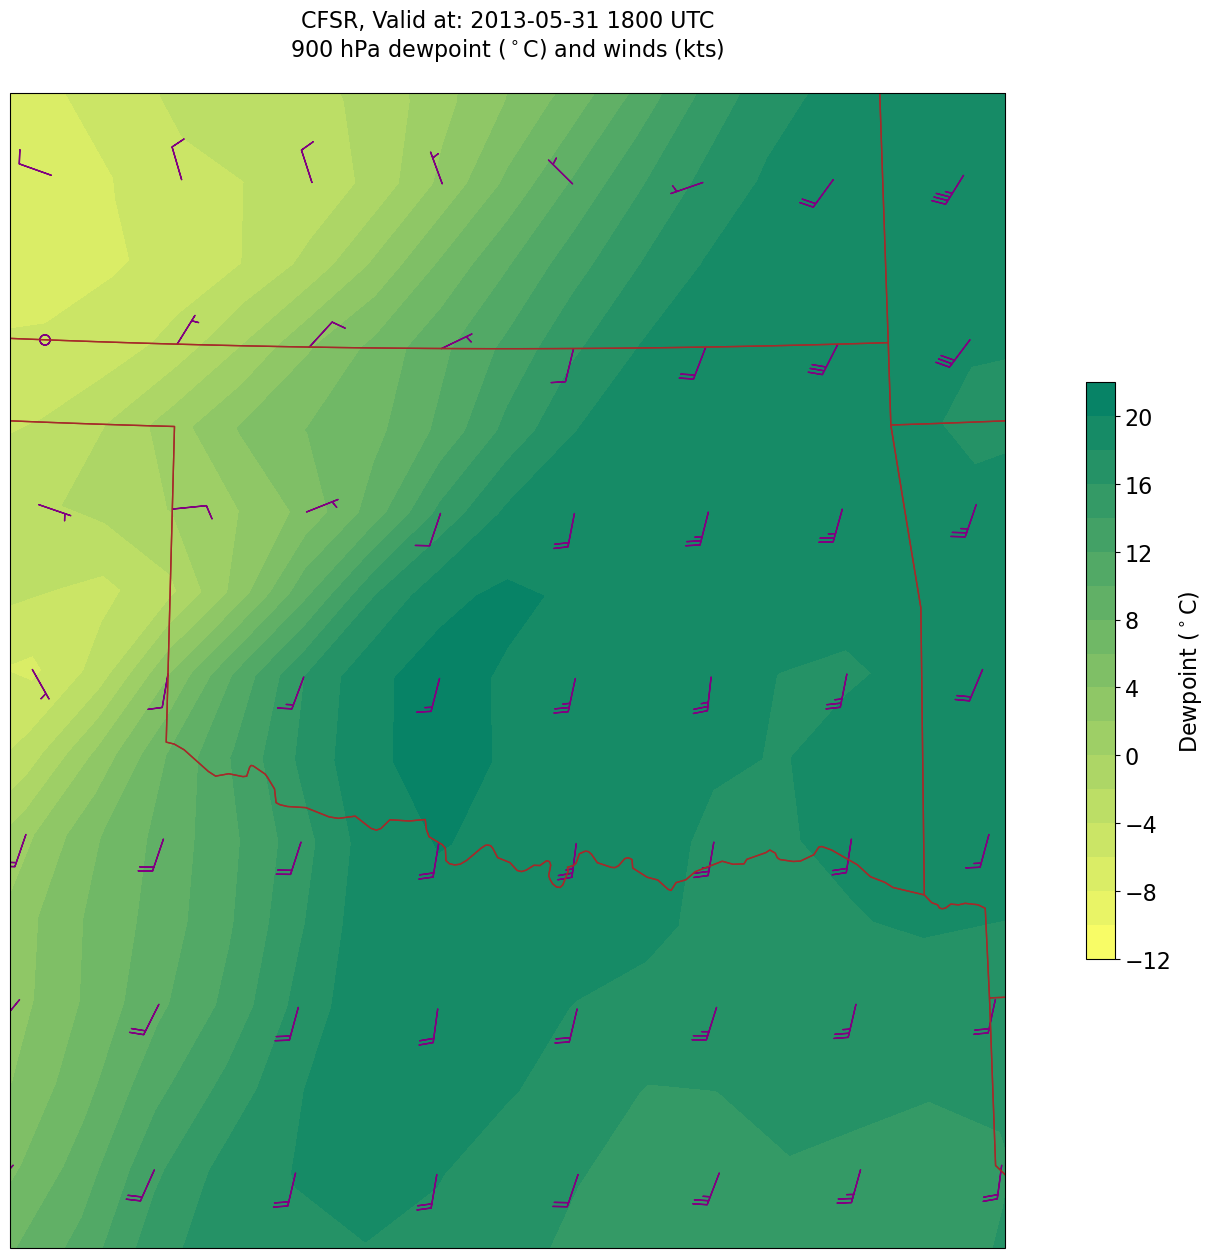

In [20]:
for time in dateList:
    print("Processing", time)
    
    
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('CFSR, Valid at: '+ timeStr)
    tl2 = levStr + " hPa dewpoint ($^\circ$C) and winds (kts)"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(21,15)) 
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
   
    cTd = ax.contourf(lons, lats, Td.sel(time=time), levels=TdContours, cmap='summer_r', transform=proj_data)
    cbar = plt.colorbar(cTd,shrink=0.5)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel("Dewpoint ($^\circ$C)",fontsize=16)
    
    CL = ax.contour(lons,lats,SLP,SLPcintervals,transform=proj_data,linewidths=1.25,colors='green')
    ax.clabel(CL, inline_spacing=0.2, fontsize=11, fmt='%.0f')


    skip = 2
    ax.barbs(lons[::skip],lats[::skip],UKts.sel(time=time)[::skip,::skip].values, VKts.sel(time=time)[::skip,::skip].values, color='purple',transform=proj_data)
    
    title = plt.title(title_line,fontsize=16)
 
    fileName = timeStrFile + '_CFSR_' + levStr + '_Td_Wind.png'
    fig.savefig(fileName)
